In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report 
import seaborn as sn
from sklearn.ensemble import StackingClassifier

import warnings 
import joblib


In [2]:
def model_performance(true_labels,predicted_labels,classes):
    conf_matrix=confusion_matrix(true_labels,predicted_labels)
    df_cm=pd.DataFrame(conf_matrix,index=classes,columns=classes)
    print("Accuracy: ",accuracy_score(true_labels,predicted_labels))
    print("Precison: ", precision_score(true_labels,predicted_labels, average='weighted'))
    print("Recall: ", recall_score(true_labels,predicted_labels, average='weighted'))
    print("F1 Score: ", f1_score(true_labels,predicted_labels, average='weighted'))
    print("Model Report: \n___________________________________________________",)
    print( classification_report(true_labels,predicted_labels))

    print("CONFUSION MATRIX: ")
    sn.heatmap(df_cm,annot=True, cmap="YlGnBu", fmt='g')

In [3]:
df = pd.DataFrame(pd.read_csv("CleanedNewsData.csv",index_col=0))


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Leanings'], test_size=0.2, random_state=43)

tv=TfidfVectorizer()
tv_train_features = tv.fit_transform(X_train)

lr = LogisticRegression()
lr.fit(tv_train_features, y_train)

X_test = [str(x) for x in X_test]
tv_test_features = tv.transform(X_test)
predicted_bias_tv = lr.predict(tv_test_features)

#model_performance(y_test,predicted_bias_tv,classes=["L","C","R"])


In [7]:
def show_test_features(vec, vec_test_features):
    vec_feature_names = vec.get_feature_names_out()
    feature_count = vec_test_features.toarray().sum(axis = 0)
    a = dict(zip(vec_feature_names, feature_count))
    #sorted_a = sorted(a.items(), key=operator.itemgetter(1), reverse=True)
    top = {}
    counter = Counter(a)
    for word, count in counter.most_common(15):
        print('%s: %i' % (word, count))

#print(show_test_features(tv,tv_test_features))
#print(show_test_features(cv,cv_test_features))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Leanings'], test_size=0.2, random_state=43)


In [9]:
def pipeline(model):
    pipeline, params = model[0], model[1]
    gs = GridSearchCV(pipeline, param_grid=params, cv=5,n_jobs=-1,verbose=1)
    gs.fit(X_train,y_train)

    print(f'Best Score: {gs.best_score_}')
    print(f'Best Parameters: {gs.best_params_}')
    print(f'Train Accuracy Score: {gs.score(X_train, y_train)}')
    print(f'Test Accuracy Score: {gs.score(X_test, y_test)}')
    
    predicted_leaning = gs.predict(X_test)
    model_performance(y_test,predicted_leaning,classes=['Left','Center','Right'])


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Score: 0.7761779595015577
Best Parameters: {'lr__C': 10.0, 'lr__penalty': 'l2', 'lr__random_state': 42, 'lr__solver': 'sag', 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__sublinear_tf': True}
Train Accuracy Score: 0.9975062344139651
Test Accuracy Score: 0.7786069651741293
Accuracy:  0.7786069651741293
Precison:  0.7795368274746486
Recall:  0.7786069651741293
F1 Score:  0.778974437824665
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.72      0.73      0.73       157
           L       0.80      0.81      0.81       121
           R       0.83      0.81      0.82       124

    accuracy                           0.78       402
   macro avg       0.79      0.78      0.78       402
weighted avg       0.78      0.78      0.78       402

CONFUSION MATRIX: 


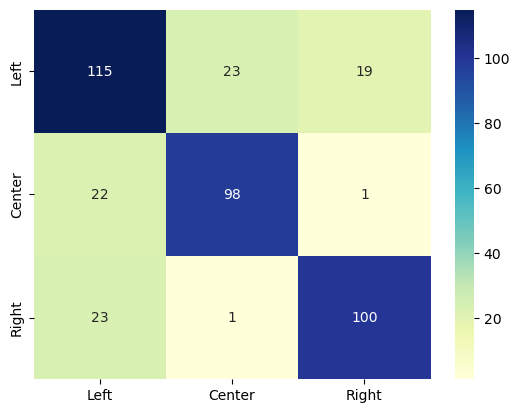

In [10]:
# 1. Logistic Regression

pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])
pipe_params_tvec_lr = {
    'tvec__max_features': [5000],
    'tvec__sublinear_tf':[True],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    'lr__C': [10.0],
    'lr__solver': ['liblinear', 'sag'],
    'lr__penalty': ['l2'],
    'lr__random_state': [42]
}
log_reg = [pipe_tvec_lr,pipe_params_tvec_lr]
pipeline(log_reg)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Score: 0.7418808411214953
Best Parameters: {'svm__alpha': 0.001, 'svm__learning_rate': 'optimal', 'svm__max_iter': 100, 'svm__penalty': 'l2', 'svm__random_state': 42, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Train Accuracy Score: 0.8958852867830424
Test Accuracy Score: 0.7487562189054726
Accuracy:  0.7487562189054726
Precison:  0.7473751520944062
Recall:  0.7487562189054726
F1 Score:  0.7468650715487414
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.72      0.66      0.69       157
           L       0.77      0.78      0.77       121
           R       0.76      0.84      0.80       124

    accuracy                           0.75       402
   macro avg       0.75      0.76      0.75       402
weighted avg       0.75      0.75      0.75       402

CONFUSION MATRIX: 


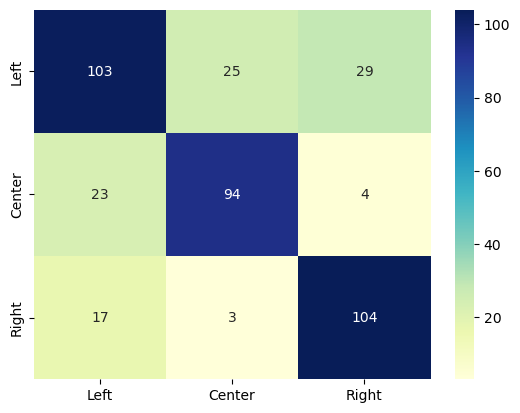

In [12]:
# 2. SVM
svm=SGDClassifier()

svm_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SGDClassifier())
])

svm_params = {
    'tvec__max_features': [5000],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    'svm__alpha': [0.001,0.01],
    'svm__penalty': ['l2'],
    'svm__learning_rate': ['optimal'],
    'svm__max_iter': [100],
    'svm__random_state':[42]
}

svm = [svm_pipe, svm_params]
pipeline(svm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score: 0.745017523364486
Best Parameters: {'rfc__max_depth': 25, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 300, 'rfc__random_state': 42, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__sublinear_tf': True}
Train Accuracy Score: 0.9993765586034913
Test Accuracy Score: 0.7587064676616916
Accuracy:  0.7587064676616916
Precison:  0.7571171601944512
Recall:  0.7587064676616916
F1 Score:  0.7542515429622074
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.72      0.64      0.68       157
           L       0.79      0.74      0.77       121
           R       0.77      0.93      0.84       124

    accuracy                           0.76       402
   macro avg       0.76      0.77      0.76       402
weighted avg       0.76      0.76      0.75       402

CONFUSION MATRIX: 


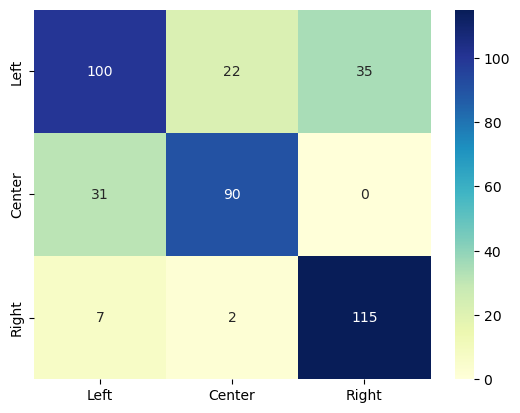

In [24]:
# 3. Random Forest
rf_pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('rfc', RandomForestClassifier())])

rf_params = [{
    'tvec__max_features': [5000],
    'tvec__sublinear_tf':[True],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    #'rfc__bootstrap': [False, True],
    'rfc__n_estimators': [200,300],
    'rfc__max_depth':[25,30],
    'rfc__max_features': ['sqrt'],
    'rfc__random_state':[42]
}]
rf = [rf_pipe, rf_params]
pipeline(rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.7431425233644859
Best Parameters: {'ada__estimator': RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=300,
                       random_state=42), 'ada__learning_rate': 1.0, 'ada__n_estimators': 300, 'ada__random_state': 42, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Train Accuracy Score: 0.9993765586034913
Test Accuracy Score: 0.763681592039801
Accuracy:  0.763681592039801
Precison:  0.763528728963512
Recall:  0.763681592039801
F1 Score:  0.7588401890525364
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.74      0.62      0.68       157
           L       0.81      0.78      0.79       121
           R       0.75      0.93      0.83       124

    accuracy                           0.76       402
   macro avg       0.77      0.78      0.77       402
weighted avg  

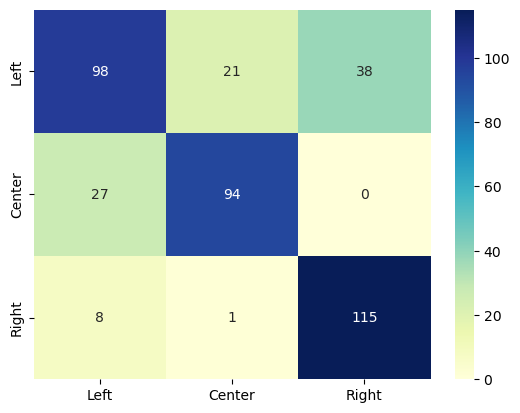

In [26]:
# 4. ADAboost
tf = TfidfVectorizer(max_features=5000,min_df=3,sublinear_tf=True,ngram_range=(1,2))
lr = LogisticRegression(C=10.0, penalty='l2', solver='sag',random_state=42,max_iter=1000)
rf = RandomForestClassifier(max_depth=25,max_features='sqrt',n_estimators=300,min_samples_leaf=1,min_samples_split=5,random_state=42)
sgd=SGDClassifier(alpha=0.001,penalty='l2',learning_rate='optimal',max_iter=100,random_state=42)

tf_train_features = tf.fit_transform(X_train)
tf_test_features = tf.transform(X_test)

lr.fit(tf_train_features,y_train)
rf.fit(tf_train_features,y_train)
sgd.fit(tf_train_features,y_train)

ada_pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('ada', AdaBoostClassifier())
])

ada_params = {
    'tvec__max_features': [5000],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    'ada__n_estimators':[300,500],
    'ada__learning_rate': [0.1,1.0],
    'ada__estimator':[rf,sgd],
    'ada__random_state':[42],
}

warnings.filterwarnings('ignore')
ada = [ada_pipe,ada_params]
pipeline(ada)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score: 0.7562285825545171
Best Parameters: {'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__sublinear_tf': True, 'xgb__learning_rate': 0.1}
Train Accuracy Score: 1.0
Test Accuracy Score: 0.7686567164179104
Accuracy:  0.7686567164179104
Precison:  0.7680655402914741
Recall:  0.7686567164179104
F1 Score:  0.7671330308058306
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       157
           1       0.78      0.69      0.73       121
           2       0.84      0.90      0.87       124

    accuracy                           0.77       402
   macro avg       0.77      0.77      0.77       402
weighted avg       0.77      0.77      0.77       402

CONFUSION MATRIX: 


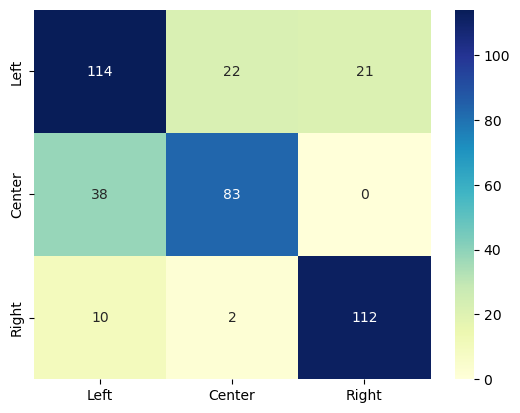

In [53]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

xgb_pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('xgb', XGBClassifier())
])

xgb_params = {
    'tvec__max_features': [5000],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    'tvec__sublinear_tf': [True],
    'xgb__learning_rate':[1,0.1,.001],
}
xgb = [xgb_pipe, xgb_params]
pipeline(xgb)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score: 0.7150915109034267
Best Parameters: {'mnb__alpha': 0.001, 'mnb__fit_prior': False, 'mnb__force_alpha': True, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__sublinear_tf': True}
Train Accuracy Score: 0.8123441396508728
Test Accuracy Score: 0.7263681592039801
Accuracy:  0.7263681592039801
Precison:  0.7224532235001752
Recall:  0.7263681592039801
F1 Score:  0.7200500705719832
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.68      0.59      0.63       157
           L       0.75      0.70      0.73       121
           R       0.75      0.93      0.83       124

    accuracy                           0.73       402
   macro avg       0.73      0.74      0.73       402
weighted avg       0.72      0.73      0.72       402

CONFUSION MATRIX: 


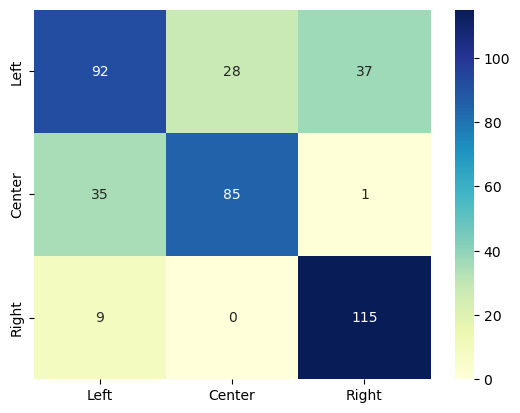

In [50]:
from sklearn.naive_bayes import MultinomialNB

pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_mnb = {
    'tvec__max_features': [5000],
    'tvec__min_df': [3],
    'tvec__ngram_range': [(1,2)],
    'tvec__sublinear_tf': [True],
    'mnb__alpha': [0.1,.001,.0005],
    'mnb__force_alpha':[True,False],
    'mnb__fit_prior': [True, False]
}

mnb= [pipe_mnb, params_mnb]
pipeline(mnb)

TFIDF Features:

say: 12
news: 11
fox: 10
fox news: 10
trump: 10
president: 9
provide: 9
people: 9
go: 9
datum: 9
right: 8
factset: 8
datum provide: 8
state: 8
tell: 8
None


Train Accuracy Score: 0.9981296758104738
Test Accuracy Score: 0.7910447761194029
Accuracy:  0.7910447761194029
Precison:  0.7915499393659102
Recall:  0.7910447761194029
F1 Score:  0.7912773990560658
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

           C       0.73      0.74      0.73       157
           L       0.82      0.81      0.81       121
           R       0.85      0.84      0.84       124

    accuracy                           0.79       402
   macro avg       0.80      0.80      0.80       402
weighted avg       0.79      0.79      0.79       402

CONFUSION MATRIX: 


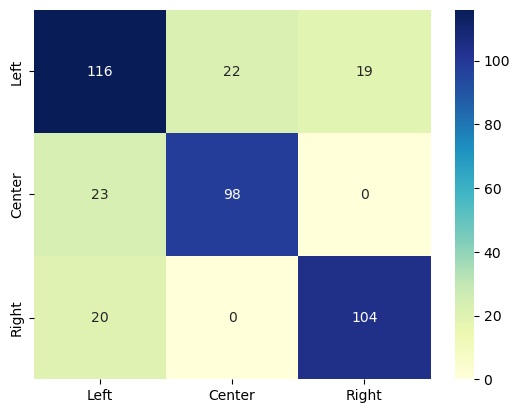

In [56]:
# 6. Stacking Classifier
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Leanings'], test_size=0.2, random_state=43)
#X_train = [str(x) for x in X_train]
#X_test = [str(x) for x in X_test]

tf = TfidfVectorizer(max_features=5000,min_df=3,sublinear_tf=True,ngram_range=(1,2))

estimators = [
    ('lr', LogisticRegression(C=10.0, penalty='l2', solver='sag',random_state=42)),
    ('svm', SGDClassifier(alpha=0.001,penalty='l2',learning_rate='optimal',max_iter=100,random_state=42)),
    ('rf', RandomForestClassifier(max_depth=25,max_features='sqrt',n_estimators=300,random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=300,learning_rate=1,estimator=rf,random_state=42)),
    ('xgb', XGBClassifier(learning_rate=0.1)),
    ('mnb', MultinomialNB(alpha=.001, fit_prior=False))

]

stacking_classifier = StackingClassifier(
    estimators = estimators,
    final_estimator=LogisticRegression(),
    passthrough=True
)

tf_train_features = tf.fit_transform(X_train)
tf_test_features = tf.transform(X_test)
stacking_classifier.fit(tf_train_features,y_train)
y_pred=stacking_classifier.predict(tf_test_features)
print('TFIDF Features:\n')
print(show_test_features(tf,tf_test_features))
print(f'\n\nTrain Accuracy Score: {stacking_classifier.score(tf_train_features, y_train)}')
print(f'Test Accuracy Score: {stacking_classifier.score(tf_test_features, y_test)}')

model_performance(y_test,y_pred,classes=['Left','Center','Right'])


In [58]:
warnings.filterwarnings('ignore')
joblib.dump(stacking_classifier, 'model.pkl', compress=9)
joblib.dump(tf,'tf.pkl',compress=9)

['tf.pkl']